In [1]:
# A bit of setup
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Lecture 8: Putting it together (Minimal Neural Network Case Study)

In this lecture we'll walk through a complete implementation of a toy Neural Network in 2 dimensions. We'll first implement a simple linear classifier and then extend the code to a 2-layer Neural Network. As we'll see, this extension is surprisingly simple and very few changes are necessary.

<hr>

## 1. Generating some data

Lets generate a classification dataset that is not easily linearly separable. Our favorite example is the spiral dataset consisting of three classes (blue, red, yellow), which can be generated as follows:

(-1, 1)

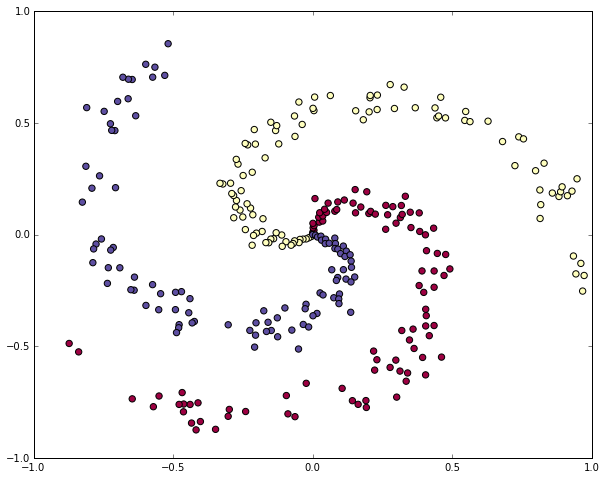

In [2]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes

X = np.zeros((N*K,D))
y = np.zeros(N*K, dtype='uint8')
for j in xrange(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j

fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])

<hr>

## 2. Preprocessing

Normally we would want to preprocess the dataset so that each feature has zero mean and unit standard deviation, but in this case the features are already in a nice range from -1 to 1, so we skip this step.

<hr>

## 3. Training a Softmax Linear Classifier

Lets first train a Softmax classifier on this classification dataset.

### Initialize the parameters

As we saw in the previous lectures, the Softmax classifier has a linear score function and uses the cross-entropy loss. The parameters of the linear classifier consist of a weight matrix `W` and a bias vector `b` for each class. Lets first initialize these parameters to be random numbers:

In [3]:
# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

Recall that `D = 2` is the dimensionality and `K = 3` is the number of classes. 

### Compute the class scores

Since this is a linear classifier, we can compute all class scores very simply in parallel with a single matrix multiplication:

In [4]:
# compute class scores for a linear classifier
scores = np.dot(X, W) + b

In this example we have 300 2-D points, so after this multiplication the array `scores` will have size `[300 x 3]`, where each row gives the class scores corresponding to the 3 classes (blue, red, yellow).

### Compute the loss

The second key ingredient we need is a loss function, which is a differentiable objective that quantifies our unhappiness with the computed class scores. Intuitively, we want the correct class to have a higher score than the other classes. When this is the case, the loss should be low and otherwise the loss should be high. There are many ways to quantify this intuition, but in this example lets use the cross-entropy loss that is associated with the Softmax classifier. Recall that if $f$ is the array of class scores for a single example (e.g. array of 3 numbers here), then the Softmax classifier computes the loss for that example as:

$$
L_i = -\log\left(\frac{\exp(f_{y_i})}{ \sum_j \exp(f_j) }\right)
$$

We can see that the Softmax classifier interprets every element of $f$ as holding the (unnormalized) log probabilities of the three classes. We exponentiate these to get (unnormalized) probabilities, and then normalize them to get probabilites. 

Therefore, the expression inside the log is the normalized probability of the correct class. Note how this expression works: this quantity is always between 0 and 1. When the probability of the correct class is very small (near 0), the loss will go towards (postiive) infinity. Conversely, when the correct class probability goes towards 1, the loss will go towards zero because $\log(1) = 0$. Hence, the expression for $L_i$ is low when the correct class probability is high, and it's very high when it is low. 

Recall also that the full Softmax classifier loss is then defined as the average cross-entropy loss over the training examples and the ridge regularization:

$$
L =  \underbrace{ \frac{1}{N} \sum_i L_i }_\text{data loss} + \underbrace{ \frac{1}{2} \lambda \sum_k\sum_l W_{k,l}^2 }_\text{regularization loss}
$$

Given the array of `scores` we've computed above, we can compute the loss. First, the way to obtain the probabilities is straight forward:

In [5]:
# get unnormalized probabilities
exp_scores = np.exp(scores)
# normalize them for each example
probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

We now have an array `probs` of size `[300 x 3]`, where each row now contains the class probabilities. In particular, since we've normalized them every row now sums to one. We can now query for the  log probabilities assigned to the correct classes in each example:

In [6]:
num_examples = X.shape[0]
correct_logprobs = -np.log(probs[range(num_examples),y])

The array `correct_logprobs` is a 1D array of just the probabilities assigned to the correct classes for each example. The full loss is then the average of these log probabilities and the regularization loss:

In [7]:
reg = 1e-3 # regularization strength

# compute the loss: average cross-entropy loss and regularization
data_loss = np.sum(correct_logprobs)/num_examples
reg_loss = 0.5*reg*np.sum(W*W)
loss = data_loss + reg_loss

print "loss %f" % loss

loss 1.100811


In this code, the regularization strength $\lambda$ is stored inside the `reg`. The convenience factor of `0.5` multiplying the regularization will become clear in a second. Evaluating this in the beginning (with random parameters) might give us `loss = 1.1`, which is `np.log(1.0/3)`, since with small initial random weights all probabilities assigned to all classes are about one third. We now want to make the loss as low as possible, with `loss = 0` as the absolute lower bound. But the lower the loss is, the higher are the probabilities assigned to the correct classes for all examples.

### Computing the Analytic Gradient with Backpropagation

We have a way of evaluating the loss, and now we have to minimize it. We'll do so with gradient descent. That is, we start with random parameters (as shown above), and evaluate the gradient of the loss function with respect to the parameters, so that we know how we should change the parameters to decrease the loss. Lets introduce the intermediate variable $p$, which is a vector of the (normalized) probabilities. The loss for one example is:

$$
p_k = \frac{\exp(f_k)}{ \sum_j \exp(f_j) } \hspace{1in} L_i =-\log\left(p_{y_i}\right).
$$

We now wish to understand how the computed scores inside $f$ should change to decrease the loss $L_i$ that this example contributes to the full objective. In other words, we want to derive the gradient $\partial L_i / \partial f_k$. The loss $L_i$ is computed from $p$, which in turn depends on $f$. It was shown to you on the blackboard how to use the chain rule to derive the gradient, and it turns out to be extremely simple and interpretible in the end, after a lot of things cancel out:

$$
\frac{\partial L_i }{ \partial f_k } = p_k - \mathbb{1}(y_i = k).
$$

Notice how elegant and simple this expression is. Suppose the probabilities we computed were `p = [0.2, 0.3, 0.5]`, and that the correct class was the middle one (with probability 0.3). According to this derivation the gradient on the scores would be `df = [0.2, -0.7, 0.5]`. Recalling what the interpretation of the gradient, we see that this result is highly intuitive: increasing the first or last element of the score vector `f` (the scores of the incorrect classes) leads to an *increased* loss (due to the positive signs +0.2 and +0.5) - and increasing the loss is bad, as expected. However, increasing the score of the correct class has *negative* influence on the loss. The gradient of -0.7 is telling us that increasing the correct class score would lead to a decrease of the loss $L_i$, which makes sense. 

All of this boils down to the following code. Recall that `probs` stores the probabilities of all classes (as rows) for each example. To get the gradient on the scores, which we call `dscores`, we proceed as follows:

In [8]:
dscores = probs
dscores[range(num_examples),y] -= 1
dscores /= num_examples

Lastly, we had that `scores = np.dot(X, W) + b`, so armed with the gradient on `scores` (stored in `dscores`), we can now backpropagate into `W` and `b`:

In [9]:
dW = np.dot(X.T, dscores)
db = np.sum(dscores, axis=0, keepdims=True)
dW += reg*W # don't forget the regularization gradient

Where we see that we have backpropped through the matrix multiply operation, and also added the contribution from the regularization. Note that the regularization gradient has the very simple form `reg*W` since we used the constant `0.5` for its loss contribution (i.e. $\frac{d}{dw} ( \frac{1}{2} \lambda w^2) = \lambda w$. This is a common convenience trick that simplifies the gradient expression.

### Performing a parameter update

Now that we've evaluated the gradient we know how every parameter influences the loss function. We will now perform a parameter update in the *negative* gradient direction to *decrease* the loss:

In [10]:
step_size = 1e-0

# perform a parameter update
W += -step_size * dW
b += -step_size * db

### Putting it all together: Training a Softmax Classifier

Putting all of this together, here is the full code for training a Softmax classifier with 200 vanilla Gradient descent steps:

In [11]:
# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in xrange(201):
  
  # evaluate class scores, [N x K]
  scores = np.dot(X, W) + b 
  
  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
  # compute the loss: average cross-entropy loss and regularization
  correct_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(correct_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W)
  loss = data_loss + reg_loss
  if i % 10 == 0:
    print "iteration %d: loss %f" % (i, loss)
  
  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples
  
  # backpropate the gradient to the parameters (W,b)
  dW = np.dot(X.T, dscores)
  db = np.sum(dscores, axis=0, keepdims=True)
  
  dW += reg*W # regularization gradient
  
  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db

iteration 0: loss 1.097415
iteration 10: loss 0.908049
iteration 20: loss 0.837344
iteration 30: loss 0.805029
iteration 40: loss 0.788127
iteration 50: loss 0.778467
iteration 60: loss 0.772602
iteration 70: loss 0.768882
iteration 80: loss 0.766445
iteration 90: loss 0.764809
iteration 100: loss 0.763689
iteration 110: loss 0.762910
iteration 120: loss 0.762363
iteration 130: loss 0.761973
iteration 140: loss 0.761694
iteration 150: loss 0.761493
iteration 160: loss 0.761347
iteration 170: loss 0.761240
iteration 180: loss 0.761162
iteration 190: loss 0.761105
iteration 200: loss 0.761062


We see that we've converged to something after about 150 or so iterations. We can evaluate the training set accuracy:

In [12]:
# evaluate training set accuracy
scores = np.dot(X, W) + b
predicted_class = np.argmax(scores, axis=1)
print 'training accuracy: %.2f' % (np.mean(predicted_class == y))

training accuracy: 0.50


This prints around **50%**. Not very good at all, but also not surprising given that the dataset is constructed so it is not linearly separable. We can also plot the learned decision boundaries:

(-1.8749426084510614, 1.8450573915489419)

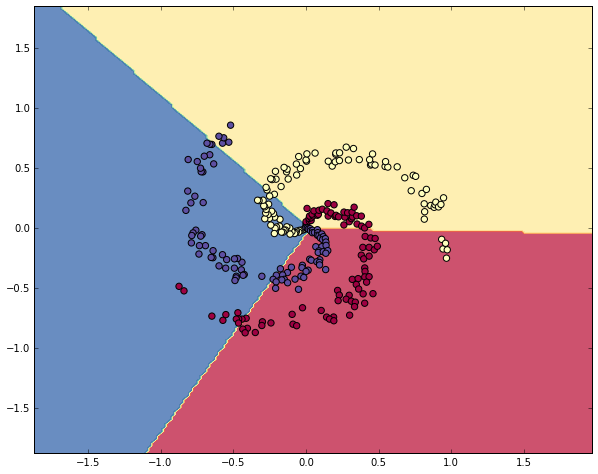

In [13]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

## 4. Training a Neural Network

Clearly, a linear classifier is inadequate for this dataset and we would like to use a Neural Network. One additional hidden layer will suffice for this toy data. We will now need two sets of weights and biases (for the first and second layers):

In [14]:
# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

The forward pass to compute scores now changes to this form:

In [15]:
# evaluate class scores with a 2-layer Neural Network
hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
scores = np.dot(hidden_layer, W2) + b2

Notice that the only change from before is one extra line of code, where we first compute the hidden layer representation and then the scores based on this hidden layer. Crucially, we've also added a non-linearity, which in this case is simple ReLU that thresholds the activations on the hidden layer at zero.

Everything else remains the same. We compute the loss based on the scores exactly as before, and get the gradient for the scores `dscores` exactly as before. However, the way we backpropagate that gradient into the model parameters now changes form, of course. First lets backpropagate the second layer of the Neural Network. This looks identical to the code we had for the Softmax classifier, except we're replacing `X` (the raw data), with the variable `hidden_layer`):

In [16]:
# backpropate the gradient to the parameters
# first backprop into parameters W2 and b2
dW2 = np.dot(hidden_layer.T, dscores)
db2 = np.sum(dscores, axis=0, keepdims=True)

However, unlike before we are not yet done, because `hidden_layer` is itself a function of other parameters and the data! We need to continue backpropagation through this variable. Its gradient can be computed as:

In [17]:
dhidden = np.dot(dscores, W2.T)

Now we have the gradient on the outputs of the hidden layer. Next, we have to backpropagate the ReLU non-linearity. This turns out to be easy because ReLU during the backward pass is effectively a switch. Since $r = \max(0, x)$, we have that $dr/dx = 1(x > 0)$. Combined with the chain rule, we see that the ReLU unit lets the gradient pass through unchanged if its input was greater than 0, but *kills it* if its input was less than zero during the forward pass. Hence, we can backpropagate the ReLU in place simply with:

In [18]:
# backprop the ReLU non-linearity
dhidden[hidden_layer <= 0] = 0

And now we finally continue to the first layer weights and biases:

In [19]:
# finally backprob into W,b
dW = np.dot(X.T, dhidden)
db = np.sum(dhidden, axis=0, keepdims=True)

We're done! We have the gradients `dW,db,dW2,db2` and can perform the parameter update. Everything else remains unchanged. The full code looks very similar:

In [20]:
# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in xrange(10000):
  
  # evaluate class scores, [N x K]
  hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
  scores = np.dot(hidden_layer, W2) + b2
  
  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
  # compute the loss: average cross-entropy loss and regularization
  correct_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(correct_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
  if i % 1000 == 0:
    print "iteration %d: loss %f" % (i, loss)
  
  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples
  
  # backpropate the gradient to the parameters
  # first backprop into parameters W2 and b2
  dW2 = np.dot(hidden_layer.T, dscores)
  db2 = np.sum(dscores, axis=0, keepdims=True)
  # next backprop into hidden layer
  dhidden = np.dot(dscores, W2.T)
  # backprop the ReLU non-linearity
  dhidden[hidden_layer <= 0] = 0
  # finally into W,b
  dW = np.dot(X.T, dhidden)
  db = np.sum(dhidden, axis=0, keepdims=True)
  
  # add regularization gradient contribution
  dW2 += reg * W2
  dW += reg * W
  
  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db
  W2 += -step_size * dW2
  b2 += -step_size * db2

iteration 0: loss 1.098664
iteration 1000: loss 0.310291
iteration 2000: loss 0.257208
iteration 3000: loss 0.251774
iteration 4000: loss 0.250232
iteration 5000: loss 0.249311
iteration 6000: loss 0.248283
iteration 7000: loss 0.247305
iteration 8000: loss 0.246242
iteration 9000: loss 0.245225


The training accuracy is now:

In [21]:
# evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(X, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print 'training accuracy: %.2f' % (np.mean(predicted_class == y))

training accuracy: 0.99


Which prints **99%**!. We can also visualize the decision boundaries:

(-1.8749426084510614, 1.8450573915489419)

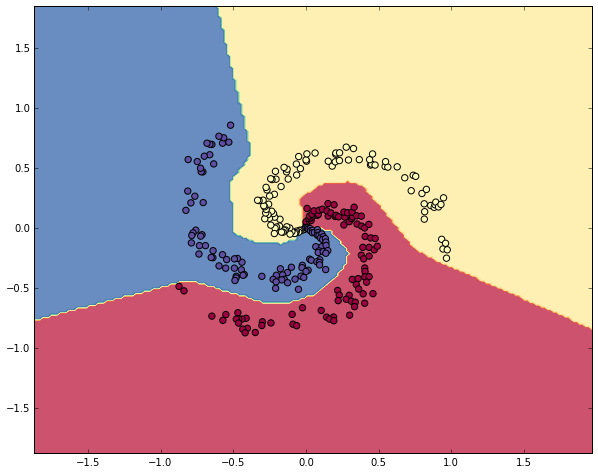

In [22]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W2) + b2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

<hr>

## 5. Summary

We've worked with a toy 2D dataset and trained both a linear network and a 2-layer Neural Network. We saw that the change from a linear classifier to a Neural Network involves very few changes in the code. The score function changes its form (1 line of code difference), and the backpropagation changes its form (we have to perform one more round of backprop through the hidden layer to the first layer of the network).